# Australia Fires

Enlace a la documentación:
https://pypi.org/project/PyMySQL/

In [81]:
import pandas as pd
import numpy as np
import pymysql.cursors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
# Connect to the database
connection = pymysql.connect(host='34.229.137.164',
                             port= 25001,
                             user='student',
                             password='lebowsky',
                             database='australia_fires_2',
                             cursorclass=pymysql.cursors.DictCursor)

In [5]:
# Create cursor and show all tables in database
cursor =  connection.cursor()
cursor.execute("SHOW TABLES")
cursor.fetchall()

[{'Tables_in_australia_fires_2': 'fire_archive_M6_96619'},
 {'Tables_in_australia_fires_2': 'fire_archive_V1_96617'},
 {'Tables_in_australia_fires_2': 'fire_nrt_M6_96619'},
 {'Tables_in_australia_fires_2': 'fire_nrt_V1_96617'},
 {'Tables_in_australia_fires_2': 'student_findings'}]

In [6]:
query = '''
SELECT *
FROM fire_archive_M6_96619
'''

tabla1 = pd.read_sql_query(query, connection)

In [7]:
query = '''
SELECT *
FROM fire_archive_V1_96617
'''

tabla2 = pd.read_sql_query(query, connection)

In [14]:
query = '''
SELECT *
FROM fire_nrt_M6_96619
'''

tabla3 = pd.read_sql_query(query, connection)

In [15]:
query = '''
SELECT *
FROM fire_nrt_V1_96617
'''

tabla4 = pd.read_sql_query(query, connection)

In [18]:
print('Shape tabla1:', tabla1.shape)
print('Shape tabla2:', tabla2.shape)
print('Shape tabla3:', tabla3.shape)
print('Shape tabla4:', tabla4.shape)

Shape tabla1: (36011, 16)
Shape tabla2: (184778, 15)
Shape tabla3: (183593, 15)
Shape tabla4: (956257, 15)


## M6 study/prediction

In [99]:
m6_train = tabla1.copy()
m6_test = tabla3.copy()

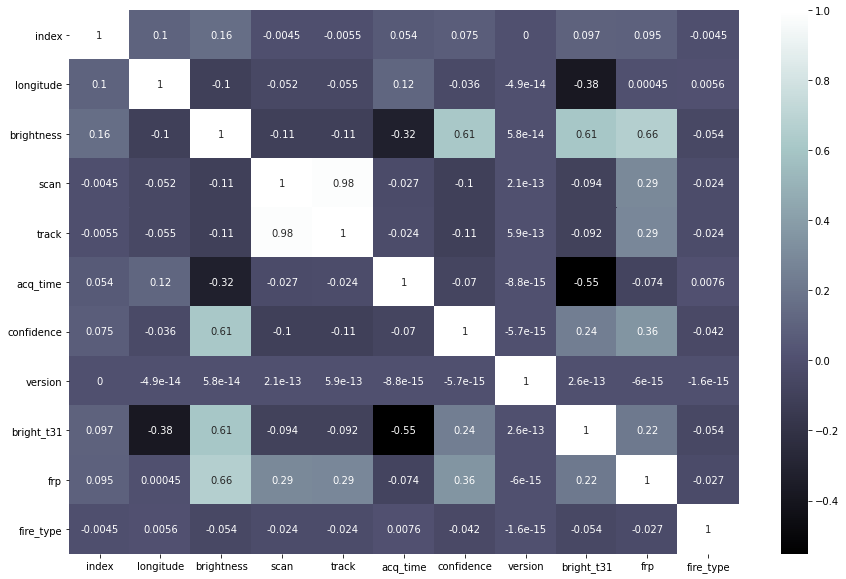

In [42]:
# Creating correlation matrix
plt.figure(figsize=(15,10))
heatmap_covid = sns.heatmap(m6_train.corr(), cmap="bone",annot=True)
fig_corr_covid = heatmap_covid.get_figure()

In [38]:
m6_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36011 entries, 0 to 36010
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       36011 non-null  int64  
 1   latitude    36011 non-null  object 
 2   longitude   36011 non-null  float64
 3   brightness  36011 non-null  float64
 4   scan        36011 non-null  float64
 5   track       36011 non-null  float64
 6   acq_date    36011 non-null  object 
 7   acq_time    36011 non-null  int64  
 8   satellite   36011 non-null  object 
 9   instrument  36011 non-null  object 
 10  confidence  36011 non-null  int64  
 11  version     36011 non-null  float64
 12  bright_t31  36011 non-null  float64
 13  frp         36011 non-null  float64
 14  daynight    36011 non-null  object 
 15  fire_type   36011 non-null  int64  
dtypes: float64(7), int64(4), object(5)
memory usage: 4.4+ MB


In [100]:
m6_train['month'] = pd.DatetimeIndex(m6_train['acq_date']).month
m6_train['latitude'] = m6_train.latitude.astype(float)

In [101]:
m6_train = m6_train[['latitude', 'longitude', 'brightness', 'scan', 'track', 'month', 'acq_time', 'satellite', 'instrument', 'confidence', 'bright_t31', 'frp', 'daynight', 'fire_type']]

In [74]:
from sklearn.preprocessing import LabelEncoder

In [102]:
# Creating dictionary of encoded categorical columns

df = m6_train
encod_cols_M6 = ['satellite', 'instrument', 'daynight']
encoder_M6 = {}
d = {}

for col in encod_cols_M6:
    encoder_M6[f'lab{col}'] = LabelEncoder()
    encoder_M6[f'lab{col}'].fit(df[f'{col}'])
    d[f'lab{col}'] = encoder_M6[f'lab{col}'].transform(df[f'{col}'])

In [103]:
# Subsituting categorical columns for encoded values

df_encoded_M6 = m6_train.copy()

for col in encod_cols_M6:
    df_encoded_M6[f'{col}'] = d[f'lab{col}']

df_encoded_M6.head()

,latitude,longitude,brightness,scan,track,month,acq_time,satellite,instrument,confidence,bright_t31,frp,daynight,fire_type
0,-11.8070,142.0583,313.0,1.0,1.0,8,56,1,0,48,297.3,6.6,0,0
1,-11.7924,142.0850,319.3,1.0,1.0,8,56,1,0,71,297.3,11.3,0,0
2,-12.8398,132.8744,311.6,3.1,1.7,8,57,1,0,42,298.7,23.1,0,0
3,-14.4306,143.3035,310.1,1.1,1.1,8,57,1,0,33,296.1,6.5,0,0
4,-12.4953,131.4897,310.3,4.0,1.9,8,57,1,0,36,298.8,27.6,0,0


### Training model

In [115]:
X_m6 = df_encoded_M6.loc[:,:'daynight']
y_m6 = df_encoded_M6.iloc[:, -1]

In [116]:
X_m6

,latitude,longitude,brightness,scan,track,month,acq_time,satellite,instrument,confidence,bright_t31,frp,daynight
0,-11.8070,142.0583,313.0,1.0,1.0,8,56,1,0,48,297.3,6.6,0
1,-11.7924,142.0850,319.3,1.0,1.0,8,56,1,0,71,297.3,11.3,0
2,-12.8398,132.8744,311.6,3.1,1.7,8,57,1,0,42,298.7,23.1,0
3,-14.4306,143.3035,310.1,1.1,1.1,8,57,1,0,33,296.1,6.5,0
4,-12.4953,131.4897,310.3,4.0,1.9,8,57,1,0,36,298.8,27.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36006,-28.0656,131.6334,312.7,1.2,1.1,9,1644,0,0,85,292.9,14.2,1
36007,-28.2625,128.5494,304.9,1.0,1.0,9,1644,0,0,27,290.9,6.4,1
36008,-28.2941,128.5123,301.7,1.0,1.0,9,1644,0,0,43,290.4,5.5,1
36009,-28.3001,128.5530,303.6,1.0,1.0,9,1644,0,0,41,290.3,5.7,1


Logistic regresion

In [82]:
from sklearn.linear_model import LogisticRegression

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_m6, y_m6, test_size=0.2, random_state=1)

# Crear modelo
log_reg = LogisticRegression()

# Entrenar modelo
log_reg.fit(X_train, y_train)

LogisticRegression()

In [118]:
# Predicciones sobre muestra de entrenamiento
print('Log reg train score', log_reg.score(X_train, y_train))

# Predicciones sobre muestra de testeo
print('Log reg test score', log_reg.score(X_test, y_test))

Log reg train score 0.9903499028047764
Log reg test score 0.9906983201443843


### Predict on test sample

In [107]:
# Clean test data

m6_test['month'] = pd.DatetimeIndex(m6_test['acq_date']).month
m6_test['latitude'] = m6_test.latitude.astype(float)
m6_test = m6_test[['latitude', 'longitude', 'brightness', 'scan', 'track', 'month', 'acq_time', 'satellite', 'instrument', 'confidence', 'bright_t31', 'frp', 'daynight']]

In [109]:
# Subsituting categorical columns for encoded values

df_encoded_M6_test = m6_test.copy()
encod_cols_M6 = ['satellite', 'instrument', 'daynight']

for col in encod_cols_M6:
    df_encoded_M6_test[f'{col}'] = encoder_M6[f'lab{col}'].transform(df_encoded_M6_test[f'{col}'])

df_encoded_M6_test.head()

,latitude,longitude,brightness,scan,track,month,acq_time,satellite,instrument,confidence,bright_t31,frp,daynight
0,-14.281,143.636,323.9,1.7,1.3,10,25,1,0,70,302.3,26.8,0
1,-14.284,143.532,343.5,1.7,1.3,10,25,1,0,90,306.3,84.3,0
2,-14.302,143.706,320.2,1.7,1.3,10,25,1,0,30,305.0,14.1,0
3,-14.283,143.652,320.4,1.7,1.3,10,25,1,0,57,303.3,18.4,0
4,-14.285,143.521,349.4,1.7,1.3,10,25,1,0,94,304.7,110.7,0


In [119]:
fire_type_M6_test = log_reg.predict(df_encoded_M6_test.values)

In [123]:
m6_entrega = tabla3.copy()
m6_entrega['fire_type'] = fire_type_M6_test
m6_entrega = m6_entrega.drop(columns='index')
m6_entrega

## V1 study/prediction

In [34]:
tabla4 = tabla4.drop('daynight', 1)

In [36]:
v1_train = tabla2.copy()
v1_test = tabla4.copy()

,index,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp
0,0,-42.69706,147.70634,333.6,0.57,0.43,2019-10-01,336,N,VIIRS,n,1.0NRT,293.4,4.0
1,1,-42.26889,147.31104,336.2,0.39,0.44,2019-10-01,336,N,VIIRS,n,1.0NRT,296.9,3.9
2,2,-40.85202,145.38068,327.9,0.46,0.47,2019-10-01,336,N,VIIRS,n,1.0NRT,295.3,3.7
3,3,-42.39329,147.47144,346.9,0.38,0.43,2019-10-01,336,N,VIIRS,n,1.0NRT,294.2,6.2
4,4,-42.69701,147.70584,334.1,0.56,0.43,2019-10-01,336,N,VIIRS,n,1.0NRT,293.5,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956252,956252,-32.66628,122.15253,306.9,0.39,0.44,2020-01-11,1630,N,VIIRS,n,1.0NRT,288.6,0.8
956253,956253,-32.58616,123.39582,299.0,0.51,0.41,2020-01-11,1630,N,VIIRS,n,1.0NRT,287.4,0.7
956254,956254,-33.37853,115.94735,309.7,0.40,0.60,2020-01-11,1630,N,VIIRS,n,1.0NRT,291.7,1.0
956255,956255,-33.21827,115.75078,300.2,0.49,0.65,2020-01-11,1806,N,VIIRS,n,1.0NRT,290.2,1.1


In [19]:
query = '''
SELECT *
FROM student_findings
'''

findings = pd.read_sql_query(query, connection)

In [21]:
findings

,index,chosen_model,acc_score,recall_score
